In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

from numba import njit

import copy
import numpy as np
import scipy as scy

In [2]:
kb = 1.380e-23 # J/K
T = 500 #K

a = 0.809
b = 0.588

In [3]:
def energy_landscape(pos) -> float:
    return kb*T*(0.28*(0.25*(a*pos[0]+b*pos[1])**4
                       + 0.1*(a*pos[0]+b*pos[1])**3
                       - 3.24*(a*pos[0]+b*pos[1])**2
                       + 6.856*(a*pos[0]-b*pos[1])**2)+3.5)


In [4]:
def metropolis(starting_position, samples, distance = 0.01):
    particle_pos = np.zeros((2,samples+1))
    particle_pos[:,0] = starting_position
    e1 = energy_landscape(starting_position)

    direction = np.zeros(2)
    for i in range(samples):
        angle = (np.random.rand() * 2 * np.pi)
        #print(angle)

        # calculate the coressponding velocities
        direction[0] = np.sin(angle) * distance
        direction[1] = np.cos(angle) * distance
        particle_pos[:,i+1] = particle_pos[:,i] + direction

        e2 = energy_landscape(particle_pos[:,i+1])
        if e2 > e1:
            logrando = np.log(np.random.rand())
            logp = -(e2-e1)/(kb*T)
            if logrando >= logp:
                particle_pos[:,i+1] -= direction
            else:
                e1 = e2
        else:
            e1 = e2
    return particle_pos


In [5]:
positions = metropolis(np.array([2,2]),10000000)

In [6]:
positions

array([[2.        , 2.00999201, 2.01972626, ..., 1.30553825, 1.311721  ,
        1.30482145],
       [2.        , 2.00039963, 2.00268969, ..., 1.70084723, 1.70870685,
        1.70146832]])

In [8]:
data, bins_x, bins_y = np.histogram2d(positions[0],positions[1], bins=100)

In [9]:
undersampled = positions[:,::100]
undersampled.shape

(2, 100001)

In [10]:
p_x, x_edges, y_edges = np.histogram2d(undersampled[0],undersampled[1], bins = 100, density=True)

In [11]:
p_x = p_x/undersampled.shape[1]

In [12]:
free_energy = np.where(p_x == 0, 0, -kb*T*np.log(p_x))
free_energy = -kb*T*np.log(p_x)

C:\Users\Peter Pain\AppData\Local\Temp\ipykernel_24664\2957043948.py:1: RuntimeWarning: divide by zero encountered in log
  free_energy = np.where(p_x == 0, 0, -kb*T*np.log(p_x))
C:\Users\Peter Pain\AppData\Local\Temp\ipykernel_24664\2957043948.py:2: RuntimeWarning: divide by zero encountered in log
  free_energy = -kb*T*np.log(p_x)


In [17]:
free_energy

array([[inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       ...,
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf]])

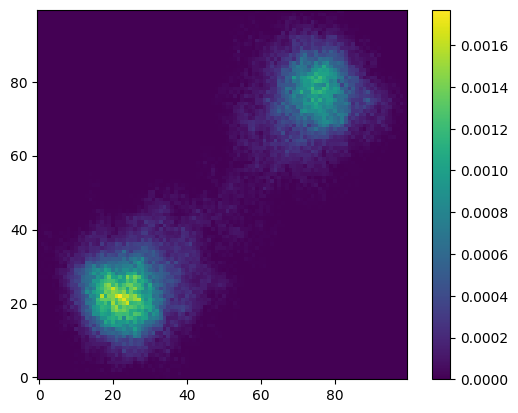

In [19]:
plt.imshow(p_x, origin='lower')
plt.colorbar()

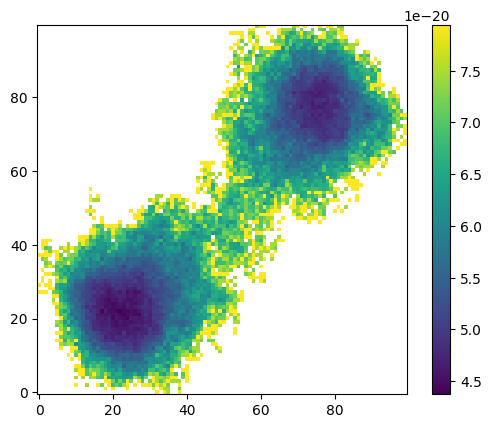

In [13]:
plt.imshow(free_energy, origin='lower')
plt.colorbar()

In [14]:
# reshape to work with np.cov
undersampled = undersampled.reshape(100001,2)
# centering the data around the mean
meaned_data = np.mean(undersampled,axis=0)
centered_data = undersampled - meaned_data

covariance_matrix = np.cov(centered_data, rowvar=False)

In [15]:
eigenvalues, eigenvector = np.linalg.eig(covariance_matrix)

In [16]:
# sorts from smallest to biggest
indices = np.argsort(eigenvalues)